In [2]:
#Importaciones
import os, json, math, time, random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix

#Comprobar la Gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device, "| CUDA:", torch.cuda.is_available())
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision('high')

#Semillas
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

#Cargar el dataset
DATA_DIR = Path("dataset_dividido_v1")
CLASSES_TXT = DATA_DIR / "classes.txt"
CLASS_IDX_JSON = DATA_DIR / "class_indices.json"

#Hiperparametros
IMG_SIZE   = 224
PATCH_SIZE = 16
EMBED_DIM  = 400     #dimension del embedding
DEPTH      = 6       #bloques del transformer
HEADS      = 10      #cabezas de atencion
MLP_RATIO  = 4       #hidden dim = 4*embed_dim = 1600 neuronillas pa'
DROPOUT    = 0.3     

BATCH_SIZE = 64
EPOCHS     = 30
LR         = 3e-4    #valor comun para transformers y AdamW
WD         = 0.05    #forzar pesos pequeños
USE_AMP    = (device.type == "cuda")

#Comprobar clases
if CLASS_IDX_JSON.exists():
    with open(CLASS_IDX_JSON,"r",encoding="utf-8") as f:
        class_map = json.load(f)
    idx2name = [class_map[str(i)] for i in range(len(class_map))]
else:
    idx2name = None
print("Idx->Name:", idx2name)


Device: cuda | CUDA: True
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Idx->Name: ['Condones', 'Cajas de condones', 'Esponjas', 'Botellas de Cloro', 'Placas madre']


In [3]:
#Preparar DataLoaders
# normalización estándar ImageNet (en las CNNS me funciono)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),

    transforms.RandomApply([transforms.ColorJitter(0.1,0.1,0.1,0.05)], p=0.3),  #ya que solo tengo 1.5k por clase aprox
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

ds = {
    "train": datasets.ImageFolder(DATA_DIR/"train", transform=train_tfms),
    "val":   datasets.ImageFolder(DATA_DIR/"val",   transform=eval_tfms),
    "test":  datasets.ImageFolder(DATA_DIR/"test",  transform=eval_tfms),
}
NUM_CLASSES = len(ds["train"].classes)
print("Clases detectadas:", ds["train"].classes)
#Crear el DataLoader
dl = {
    "train": DataLoader(ds["train"], batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True),
    "val":   DataLoader(ds["val"],   batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True),
    "test":  DataLoader(ds["test"],  batch_size=BATCH_SIZE*2, shuffle=False, num_workers=2, pin_memory=True),
}


Clases detectadas: ['Botellas de Cloro', 'Cajas de condones', 'Condones', 'Esponjas', 'Placas madre']


In [ ]:
#Architectura del modelo (basada en Atention is all you need)
#Bloque de atencion
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, heads):
        super().__init__()
        assert embed_dim % heads == 0
        self.heads = heads
        self.head_dim = embed_dim // heads

        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, mask=None): #calculamos atencion
        B, N, D = x.shape #batch, num tokens, embedding dim
        q = self.W_q(x).reshape(B, N, self.heads, self.head_dim).transpose(1, 2)
        k = self.W_k(x).reshape(B, N, self.heads, self.head_dim).transpose(1, 2)
        v = self.W_v(x).reshape(B, N, self.heads, self.head_dim).transpose(1, 2)
        #se podria haber usado layernorm pero no se si es mejor o peor
        attn = (q @ k.transpose(-2,-1)) / math.sqrt(self.head_dim) #mantenido por aladdin persson creo que para estabizar los gradientes
        if mask is not None: #me imagino que siempre va a ser None
            attn = attn.masked_fill(mask==0, float("-inf"))
        attn = attn.softmax(dim=-1)
        out = attn @ v
        out = out.transpose(1,2).reshape(B,N,D)
        return self.proj(out)

#Bloque transformer
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads, mlp_ratio=4, drop=0.3):
        super().__init__()
        self.attn = SelfAttention(embed_dim, heads)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim*mlp_ratio), #expansion
            nn.GELU(), #mejor que relu en transformers(segun ViT y BERT)
            nn.Dropout(drop),
            nn.Linear(embed_dim*mlp_ratio, embed_dim), #reduccion
        )
        self.drop = nn.Dropout(drop)

    def forward(self, x, mask=None):
        x = x + self.drop(self.attn(self.ln1(x), mask))
        x = x + self.drop(self.mlp(self.ln2(x)))
        return x

#Convertir imagenes en parches
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_ch=3, embed_dim=400):
        super().__init__()
        self.grid = img_size // patch_size #14 si 224/16
        self.num_patches = self.grid * self.grid
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1,2)  # [B,N,D]
        return x


class ResiduosTransformer(nn.Module):
    def __init__(self, num_classes=5, img_size=224, patch_size=16,
                 embed_dim=400, depth=6, heads=10, mlp_ratio=4, drop=0.3):
        super().__init__()
        self.patch = PatchEmbed(img_size, patch_size, 3, embed_dim) #Convertimos las en parches
        n_tokens = self.patch.num_patches + 1 #aumentamos 1 por el token de clase
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim)) #token de prediccion
        self.pos_embed = nn.Parameter(torch.zeros(1,n_tokens,embed_dim)) #posicion para cada token con su parche
        self.pos_drop  = nn.Dropout(drop) #evitamos que el modelo dependa demasiado de posiciones especificas
        #Encoder
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, heads, mlp_ratio, drop) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) #pasar del embedding a las clases
        #Asegurando la inicializacion en valores bajos
        nn.init.trunc_normal_(self.pos_embed,std=0.02)
        nn.init.trunc_normal_(self.cls_token,std=0.02)
        nn.init.trunc_normal_(self.head.weight,std=0.02)
        nn.init.constant_(self.head.bias,0)

    def forward(self, x):
        B = x.size(0)
        x = self.patch(x)
        cls = self.cls_token.expand(B,-1,-1)
        x = torch.cat([cls,x], dim=1)
        x = self.pos_drop(x + self.pos_embed[:,:x.size(1)])
        for blk in self.blocks: x = blk(x)
        x = self.norm(x)
        return self.head(x[:,0])


In [ ]:
#Entrenamiento
criterion = nn.CrossEntropyLoss(label_smoothing=0.05) #reducimos la confianza del modelo en sus predicciones
model = ResiduosTransformer(NUM_CLASSES, IMG_SIZE, PATCH_SIZE, EMBED_DIM, DEPTH, HEADS, MLP_RATIO, DROPOUT).to(device)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LR*0.05) #con el 5% del lr inicial (evitando que el lr sea demasiado bajo)
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler(enabled=USE_AMP)

best_val=float("inf"); patience=7; bad=0
BEST_PATH = Path("best_residuos_transformer.pt")

def run_epoch(loader, train=True):
    model.train(train)
    tot_loss=tot_corr=tot=0
    for xb,yb in loader:
        xb,yb=xb.to(device), yb.to(device)
        with autocast(enabled=USE_AMP):
            logits = model(xb)
            loss = criterion(logits,yb)
        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            scaler.step(optimizer); scaler.update()
        tot+=yb.size(0)
        tot_loss+=loss.item()*yb.size(0)
        tot_corr+=(logits.argmax(1)==yb).sum().item()
    return tot_loss/tot, tot_corr/tot

print("Entrenando Transformer")
for ep in range(1,EPOCHS+1):
    tr_loss,tr_acc=run_epoch(dl["train"],True)
    va_loss,va_acc=run_epoch(dl["val"],False)
    scheduler.step()
    print(f"[{ep:02d}/{EPOCHS}] train={tr_loss:.4f}/{tr_acc:.4f} | val={va_loss:.4f}/{va_acc:.4f}")
    if va_loss<best_val-1e-4:
        best_val=va_loss; bad=0
        torch.save(model.state_dict(),BEST_PATH)
    else:
        bad+=1
        if bad>=patience:
            print("Para emocion"); break


C:\Users\jhean\AppData\Local\Temp\ipykernel_13628\435922327.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=USE_AMP)


Entrenando Transformer


C:\Users\jhean\AppData\Local\Temp\ipykernel_13628\435922327.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=USE_AMP):


[01/30] train=1.2923/0.4784 | val=1.2076/0.5392
[02/30] train=1.1376/0.5619 | val=1.1376/0.5643
[03/30] train=1.0826/0.6008 | val=1.0558/0.6176
[04/30] train=1.0396/0.6253 | val=1.2286/0.5235
[05/30] train=1.0029/0.6389 | val=1.0789/0.6144
[06/30] train=0.9514/0.6622 | val=0.9888/0.6646
[07/30] train=0.9310/0.6796 | val=1.0362/0.6364
[08/30] train=0.8918/0.6933 | val=1.0346/0.6426
[09/30] train=0.8708/0.7009 | val=1.0038/0.6646
[10/30] train=0.8444/0.7216 | val=1.0671/0.6113
[11/30] train=0.8008/0.7426 | val=0.8786/0.7273
[12/30] train=0.7787/0.7551 | val=1.0361/0.6740
[13/30] train=0.7537/0.7649 | val=0.9477/0.6803
[14/30] train=0.7246/0.7781 | val=1.0036/0.6614
[15/30] train=0.6970/0.7894 | val=0.9182/0.6991
[16/30] train=0.6874/0.7986 | val=0.9863/0.6803
[17/30] train=0.6544/0.8150 | val=0.9299/0.6897
[18/30] train=0.6119/0.8291 | val=1.0027/0.6865
Para emocion


TEST acc: 0.685501066098081


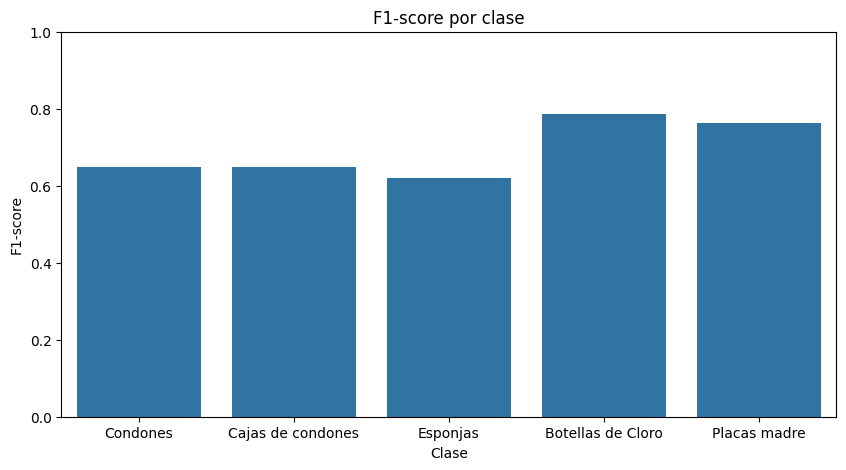

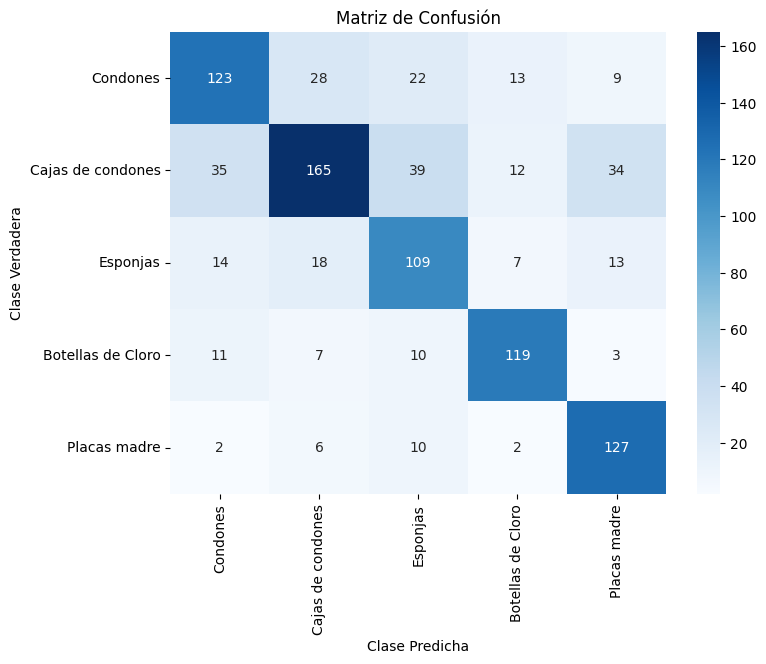

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

state = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(state)
model.eval()

all_true, all_pred = [], []
with torch.no_grad():
    for xb, yb in dl["test"]:
        xb = xb.to(device)
        logits = model(xb)
        all_pred.append(logits.argmax(1).cpu().numpy())
        all_true.append(yb.numpy())
y_true = np.concatenate(all_true)
y_pred = np.concatenate(all_pred)

test_acc = (y_true == y_pred).mean()
print("TEST acc:", test_acc)

names = idx2name if idx2name else [str(i) for i in range(NUM_CLASSES)]

#Graficas
report = classification_report(y_true, y_pred, target_names=names, digits=4, output_dict=True)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(report.keys())[:-3], y=[report[n]['f1-score'] for n in names])
plt.title('F1-score por clase')
plt.ylabel('F1-score')
plt.xlabel('Clase')
plt.ylim(0, 1)
plt.show()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=names, yticklabels=names)
plt.title('Matriz de Confusión')
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()